<h1><b>Задача по предсказанию рейтинга шоколада

<h3><b>Никнейм на Kaggle: 

# Описание задачи

In [93]:
# Даны характеристики шоколадок и по ним нужно предсказать их рейтинг.

# Описание данных
# Company - компания производитель
# Specific Bean Origin - географический регион происхождения
# REF - параметр, определяющий момент внесения записи в базу данных (чем выше значение, тем "свежее" запись)
# Review - дата публикации отзыва
# Cocoa Percent - процентное содержание какао
# Company Location - страна производитель
# Rating - экспертный рейтинг
# Bean Type - используемый сорт какао-бобов, если таковой имеется
# Broad Bean Origin - географический регион происхождения какао-бобов

# Файлы с данными
# choco_train.csv - тренировочные данные
# choco_test_new.csv - тестовые данные
# choco_sample_submission.csv - пример submission

# Импорт библиотек, константы

In [94]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [95]:
import warnings
warnings.filterwarnings("ignore")

In [96]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler, PolynomialFeatures
from category_encoders.ordinal import OrdinalEncoder
from category_encoders.one_hot import OneHotEncoder
from category_encoders.target_encoder import TargetEncoder
from category_encoders.leave_one_out import LeaveOneOutEncoder
from sklearn.preprocessing import LabelEncoder

In [97]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor, CatBoostClassifier
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import StackingRegressor
import optuna

In [98]:
from association_metrics import CramersV
import phik
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import r2_score
from sklearn.pipeline import Pipeline

In [99]:
SEED = 4784

<!-- # Загрузка данных -->

# Загрузка данных

In [100]:
# TRAIN = "https://raw.githubusercontent.com/evgpat/edu_stepik_practical_ml/main/datasets/chocolate_train.csv"
# TEST = "https://raw.githubusercontent.com/evgpat/edu_stepik_practical_ml/main/datasets/chocolate_test_new.csv"
TRAIN = 'data\chocolate-rating\chocolate_train.csv'
TEST = 'data\chocolate-rating\chocolate_test_new.csv'

In [101]:
train = pd.read_csv(TRAIN)

In [102]:
test = pd.read_csv(TEST)

In [103]:
train['Bean Type'].value_counts().index[0]

'\xa0'

# Обзор данных

Описание данных
* Company - компания производитель
* Specific Bean Origin - географический регион происхождения
* REF - параметр, определяющий момент внесения записи в базу данных (чем выше значение, тем "свежее" запись)
* Review - дата публикации отзыва
* Cocoa Percent - процентное содержание какао
* Company Location - страна производитель
* Rating - экспертный рейтинг
* Bean Type - используемый сорт какао-бобов, если таковой имеется
* Broad Bean Origin - географический регион происхождения какао-бобов

In [104]:
test.head()

,Company,Specific Bean Origin,REF,Review,Cocoa Percent,Company Location,Bean Type,Broad Bean Origin
0,Ohiyo,"San Juan Estate, Gran Couva",1594,2015,70%,U.S.A.,Trinitario,Trinidad
1,Blanxart,Organic Dark,322,2009,72%,Spain,,
2,Brazen,Maya Mountain,1518,2015,80%,U.S.A.,Trinitario,Belize
3,Patric,Madagascar,439,2009,67%,U.S.A.,Trinitario,Madagascar
4,Potomac,"Upala, Batch 12",607,2010,82%,U.S.A.,Matina,Costa Rica


In [105]:
test.nunique()

Company                 244
Specific Bean Origin    385
REF                     338
Review                   12
Cocoa Percent            38
Company Location         42
Bean Type                20
Broad Bean Origin        60
dtype: int64

In [106]:
test.nunique()

Company                 244
Specific Bean Origin    385
REF                     338
Review                   12
Cocoa Percent            38
Company Location         42
Bean Type                20
Broad Bean Origin        60
dtype: int64

In [107]:
train = train.replace('\xa0', np.NaN)
test = test.replace('\xa0', np.NaN)

In [108]:
train['splitted_df'] = 'train'
test['splitted_df'] = 'test'

In [109]:
train_clean = train.copy()
test_clean = test.copy()

In [110]:
df_concat = pd.concat([train_clean, test_clean], axis=0)

In [111]:
def bean_type_mapping(value):
    bean_types = {
    'Amazonian': ['Amazon', 'Amazon mix', 'Amazon, ICS'],
    'Blend': ['Blend', 'Blend-Forastero,Criollo', 'Criollo, Forastero', 'Criollo, Trinitario', 
              'Forastero, Trinitario', 'Trinitario, Criollo', 'Trinitario, Forastero',
              'Trinitario, Nacional', 'Trinitario, TCGA'],
    'Criollo': ['Criollo', 'Criollo (Amarru)', 'Criollo (Ocumare 61)', 'Criollo (Ocumare 67)',
                'Criollo (Ocumare 77)', 'Criollo (Ocumare)', 'Criollo (Porcelana)', 'Criollo (Wild)', 'Criollo, +'],
    'Forastero': ['Forastero', 'Forastero (Amelonado)', 'Forastero (Arriba)', 'Forastero (Arriba) ASS',
                  'Forastero (Arriba) ASSS', 'Forastero (Catongo)', 'Forastero (Nacional)', 'Forastero (Parazinho)',
                  'Forastero(Arriba, CCN)'],
    'Nacional': ['Nacional', 'Nacional (Arriba)'],
    'Trinitario': ['Trinitario', 'Trinitario (85% Criollo)', 'Trinitario (Amelonado)', 'Trinitario (Scavina)']
    }
    
    for group, values in bean_types.items():
        if value in values:
            return group
    return value

In [112]:
def bb_origin_mapping(value):
    bb_origins = {
    'Carribean': ['Carribean', 'Carribean(DR/Jam/Tri)', 'Africa, Carribean, C. Am.'],
    'Colombia': ['Colombia', 'Colombia, Ecuador'],
    'Costa Rica': ['Costa Rica', 'Cost Rica, Ven'],
    'Dominican Republic': ['Dominican Republic', 'DR, Ecuador, Peru', 'Dom. Rep., Madagascar', 
                           'Domincan Republic', 'Dominican Rep., Bali'],
    'Ecuador': ['Ecuador', 'Ecuador, Costa Rica', 'Ecuador, Mad., PNG'],
    'Ghana': ['Ghana', 'Ghana & Madagascar', 'Ghana, Domin. Rep', 'Ghana, Panama, Ecuador'],
    'Grenada': ['Grenada', 'Gre., PNG, Haw., Haiti, Mad'],
    'Guatemala': ['Guatemala', 'Guat., D.R., Peru, Mad., PNG',],
    'Indonesia': ['Indonesia', 'Indonesia, Ghana'],
    'Madagascar': ['Madagascar', 'Madagascar & Ecuador','Mad., Java, PNG'],
    'Papua New Guinea': ['Papua New Guinea', 'PNG, Vanuatu, Mad'],
    'Peru': ['Peru', 'Peru(SMartin,Pangoa,nacional)', 'Peru, Belize', 'Peru, Dom. Rep', 'Peru, Ecuador',
    'Peru, Ecuador, Venezuela', 'Peru, Mad., Dom. Rep.', 'Peru, Madagascar'],
    'Sao Tome': ['Sao Tome', 'Sao Tome & Principe'],
    'South America': ['South America', 'South America, Africa', 'Central and S. America'],
    'Trinidad': ['Trinidad', 'Trinidad, Ecuador', 'Trinidad, Tobago', 'Trinidad-Tobago',],
    'Venezuela': ['Venezuela', 'Ven, Bolivia, D.R.', 'Ven, Trinidad, Ecuador', 'Ven., Indonesia, Ecuad.',
                  'Ven., Trinidad, Mad.', 'Ven.,Ecu.,Peru,Nic.', 'Venez,Africa,Brasil,Peru,Mex',
                  'Venezuela, Carribean', 'Venezuela, Dom. Rep.', 'Venezuela, Ghana', 'Venezuela, Java',
                  'Venezuela, Trinidad', 'Venezuela/ Ghana']
    }
    
    for group, values in bb_origins.items():
        if value in values:
            return group
    return value

In [113]:
def df_mapping(df):
    df['Bean Type'] = df['Bean Type'].apply(bean_type_mapping)
    df['Broad Bean Origin'] = df['Broad Bean Origin'].apply(bb_origin_mapping)

In [114]:
df_mapping(train_clean)
df_mapping(test_clean)

In [115]:
df_concat['Cocoa Percent'] = df_concat['Cocoa Percent'].str.rstrip('%').astype(np.float32)

In [116]:
train.isna().sum()

Company                   0
Specific Bean Origin      0
REF                       0
Review                    0
Cocoa Percent             0
Company Location          0
Rating                    0
Bean Type               629
Broad Bean Origin        56
splitted_df               0
dtype: int64

In [117]:
# stop

In [118]:
df_concat

,Company,Specific Bean Origin,REF,Review,Cocoa Percent,Company Location,Rating,Bean Type,Broad Bean Origin,splitted_df
0,Willie's Cacao,Rio Caribe,457,2009,72.0,U.K.,3.25,Trinitario,Venezuela,train
1,Beschle (Felchlin),"Ocumare, Premier Cru, Quizas No. 2",508,2010,72.0,Switzerland,3.50,NaN,Venezuela,train
2,Dark Forest,Tanzania,1554,2015,70.0,U.S.A.,3.00,NaN,Tanzania,train
3,Brasstown aka It's Chocolate,Cooproagro,1125,2013,72.0,U.S.A.,3.00,Trinitario,Dominican Republic,train
4,Pralus,"Java, Indonesie",32,2006,75.0,France,3.50,Criollo,Indonesia,train
...,...,...,...,...,...,...,...,...,...,...
535,Monsieur Truffe,Papaua New Guinea,1391,2014,70.0,Australia,NaN,NaN,Papua New Guinea,test
536,Cacao Hunters,Macondo,1816,2016,71.0,Colombia,NaN,NaN,Colombia,test
537,Bonnat,Maragnam,1038,2013,75.0,France,NaN,NaN,Brazil,test
538,Altus aka Cao Artisan,Acopagro,1728,2016,60.0,U.S.A.,NaN,NaN,Peru,test


In [119]:
phik_overview = phik.phik_matrix(df_concat.drop(columns=['Rating', 'splitted_df'], axis=1))
# phik_overview['Rating'].sort_values(ascending=False)
phik_overview

interval columns not set, guessing: ['REF', 'Review', 'Cocoa Percent']


,Company,Specific Bean Origin,REF,Review,Cocoa Percent,Company Location,Bean Type,Broad Bean Origin
Company,1.000000,0.000000,0.944614,0.937287,0.806938,0.999981,0.952623,0.959022
Specific Bean Origin,0.000000,1.000000,0.779049,0.794767,0.726344,0.965506,0.997778,0.999945
REF,0.944614,0.779049,1.000000,0.991009,0.244674,0.670272,0.501838,0.523766
Review,0.937287,0.794767,0.991009,1.000000,0.258717,0.681835,0.544777,0.532581
Cocoa Percent,0.806938,0.726344,0.244674,0.258717,1.000000,0.656098,0.102838,0.665528
Company Location,0.999981,0.965506,0.670272,0.681835,0.656098,1.000000,0.770285,0.928883
Bean Type,0.952623,0.997778,0.501838,0.544777,0.102838,0.770285,1.000000,0.905284
Broad Bean Origin,0.959022,0.999945,0.523766,0.532581,0.665528,0.928883,0.905284,1.000000


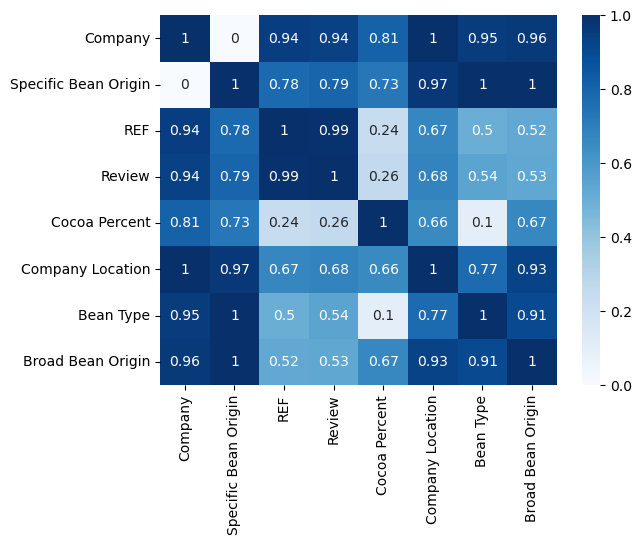

In [120]:
sns.heatmap(phik_overview, cmap='Blues', annot=True);

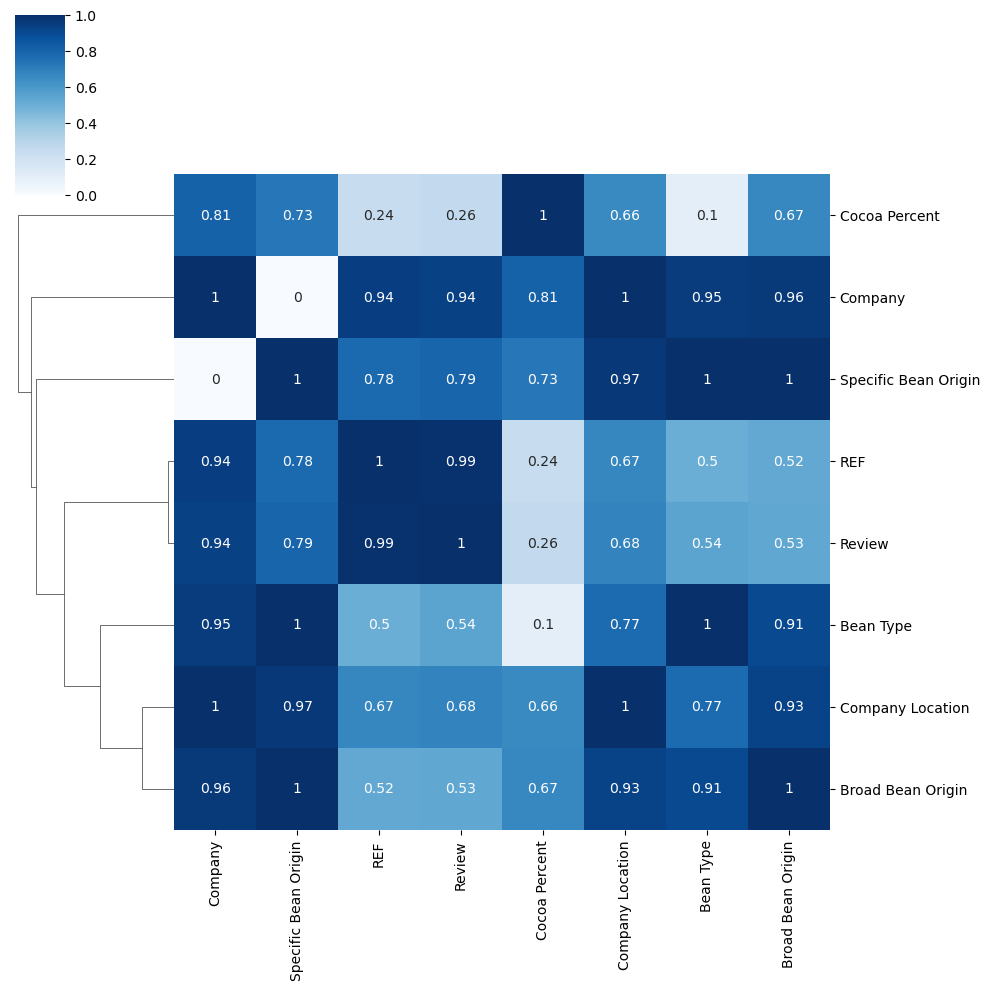

In [121]:
sns.clustermap(phik_overview, cmap='Blues', annot=True, col_cluster=False);

In [122]:
# stop

In [123]:
df_concat.isna().sum()

Company                   0
Specific Bean Origin      0
REF                       0
Review                    0
Cocoa Percent             0
Company Location          0
Rating                  540
Bean Type               888
Broad Bean Origin        74
splitted_df               0
dtype: int64

In [124]:
train_clean['Review'] = train_clean['Review'].astype('object')
test_clean['Review'] = test_clean['Review'].astype('object')

In [125]:
train.dtypes

Company                  object
Specific Bean Origin     object
REF                       int64
Review                    int64
Cocoa Percent            object
Company Location         object
Rating                  float64
Bean Type                object
Broad Bean Origin        object
splitted_df              object
dtype: object

In [126]:
train_clean.columns

Index(['Company', 'Specific Bean Origin', 'REF', 'Review', 'Cocoa Percent',
       'Company Location', 'Rating', 'Bean Type', 'Broad Bean Origin',
       'splitted_df'],
      dtype='object')

In [127]:
train_clean.isna().sum()

Company                   0
Specific Bean Origin      0
REF                       0
Review                    0
Cocoa Percent             0
Company Location          0
Rating                    0
Bean Type               629
Broad Bean Origin        56
splitted_df               0
dtype: int64

In [128]:
def select_top_corr_cols(col_in):
    select_df = phik_overview[col_in].sort_values(ascending=False)
    return select_df[1:].index.to_list()

In [155]:
def get_temp_df(col_in, col_on, SEED):
    np.random.seed(SEED)
    temp_df = df_concat.groupby(col_on)[col_in] \
                        .agg(lambda x: (x.mode()[0]) if len(x.mode()) > 0 else np.NaN) \
                        .dropna().reset_index()
    display(temp_df)
    return temp_df

In [156]:
def fill_rows(row, col_on, temp_df):
    for variants, category in temp_df.values:
        if row[col_on] == variants:
            return category
    return np.NaN

In [157]:
train.isna().sum()

Company                 0
Specific Bean Origin    0
REF                     0
Review                  0
Cocoa Percent           0
Company Location        0
Rating                  0
Bean Type               0
Broad Bean Origin       0
splitted_df             0
dtype: int64

In [158]:
def prepared_df(df, col_in, SEED):

    selected_cols = select_top_corr_cols(col_in)
    print(selected_cols)
    for col_on in selected_cols:
        temp_df = get_temp_df(col_in, col_on, SEED)
        df[col_in] = df.apply(lambda row: fill_rows(row, col_on, temp_df) if row[col_in] is np.NaN else row[col_in], axis=1)
        df[col_in] = df[col_in].fillna('Other')

In [159]:
cols_in = ['Bean Type', 'Broad Bean Origin']

for col_in in cols_in:
    prepared_df(train, col_in, SEED)

for col_in in cols_in:
    prepared_df(test, col_in, SEED)

['Specific Bean Origin', 'Company', 'Broad Bean Origin', 'Company Location', 'Review', 'REF', 'Cocoa Percent']


,Specific Bean Origin,Bean Type
0,"""heirloom"", Arriba Nacional",Forastero (Nacional)
1,2009 Hapa Nibby,Blend
2,ABOCFA Coop,Forastero
3,Abinao,Forastero
4,"Acul-du-Nord, 2015","Criollo, Trinitario"
...,...,...
548,"Winak, Sumaco",Forastero (Nacional)
549,Xoconusco,Criollo
550,"Xoconusco, Chiapas",Criollo
551,"Xoconusco, cacao Real",Criollo


,Company,Bean Type
0,A. Morin,Criollo
1,AMMA,Forastero (Parazinho)
2,Acalli,Criollo
3,Adi,Trinitario
4,Aequare (Gianduja),Forastero (Arriba)
...,...,...
279,hello cocoa,Criollo
280,hexx,Trinitario
281,iQ Chocolate,Criollo
282,organicfair,Trinitario


,Broad Bean Origin,Bean Type
0,Belize,Trinitario
1,Bolivia,Criollo
2,Brazil,Forastero (Parazinho)
3,Cameroon,Forastero
4,Carribean,Trinitario
...,...,...
61,"Venezuela, Ghana","Trinitario, Forastero"
62,"Venezuela, Java",Blend
63,Venezuela/ Ghana,Blend
64,Vietnam,Trinitario


,Company Location,Bean Type
0,Amsterdam,Trinitario
1,Argentina,Forastero (Nacional)
2,Australia,Trinitario
3,Austria,"Criollo, Trinitario"
4,Belgium,Criollo
5,Brazil,Forastero (Parazinho)
6,Canada,Trinitario
7,Chile,Criollo
8,Colombia,Forastero (Nacional)
9,Costa Rica,Forastero


,Review,Bean Type
0,2006,Trinitario
1,2007,Trinitario
2,2008,Forastero (Arriba)
3,2009,Trinitario
4,2010,Trinitario
5,2011,Trinitario
6,2012,Trinitario
7,2013,Trinitario
8,2014,Trinitario
9,2015,Trinitario


,REF,Bean Type
0,5,Trinitario
1,15,Forastero
2,24,Trinitario
3,32,Forastero (Nacional)
4,40,Trinitario
...,...,...
370,1912,Criollo
371,1916,Trinitario
372,1920,"Criollo, Trinitario"
373,1924,Forastero (Nacional)


,Cocoa Percent,Bean Type
0,50.0,Forastero (Parazinho)
1,53.0,Forastero (Nacional)
2,55.0,Forastero (Arriba)
3,57.0,Forastero
4,58.0,Forastero (Arriba) ASS
5,60.0,Trinitario
6,60.5,Trinitario
7,61.0,Blend
8,62.0,Blend
9,63.0,Trinitario


['Specific Bean Origin', 'Company', 'Company Location', 'Bean Type', 'Cocoa Percent', 'Review', 'REF']


,Specific Bean Origin,Broad Bean Origin
0,"""heirloom"", Arriba Nacional",Ecuador
1,2009 Hapa Nibby,"Dominican Rep., Bali"
2,"A case of the Xerces Blues, triple roast",Nicaragua
3,ABOCFA Coop,Ghana
4,Abinao,West Africa
...,...,...
976,Zorzal Reserva w/ Charles Kerchner,Dominican Republic
977,black label,Peru
978,la Amistad,Costa Rica
979,single estate,Costa Rica


,Company,Broad Bean Origin
0,A. Morin,Peru
1,AMMA,Brazil
2,Acalli,Peru
3,Adi,Fiji
4,Aequare (Gianduja),Ecuador
...,...,...
404,hello cocoa,Uganda
405,hexx,Ecuador
406,iQ Chocolate,Peru
407,organicfair,Dominican Republic


,Company Location,Broad Bean Origin
0,Amsterdam,Congo
1,Argentina,Venezuela
2,Australia,Papua New Guinea
3,Austria,Peru
4,Belgium,Venezuela
5,Bolivia,Bolivia
6,Brazil,Brazil
7,Canada,Venezuela
8,Chile,Peru
9,Colombia,Colombia


,Bean Type,Broad Bean Origin
0,Amazon,Belize
1,Amazon mix,Costa Rica
2,"Amazon, ICS",Bolivia
3,Beniano,Bolivia
4,Blend,Hawaii
5,"Blend-Forastero,Criollo",Dominican Republic
6,CCN51,Colombia
7,Criollo,Venezuela
8,Criollo (Amarru),Peru
9,Criollo (Ocumare 61),Venezuela


,Cocoa Percent,Broad Bean Origin
0,42.0,Martinique
1,46.0,"Colombia, Ecuador"
2,50.0,Brazil
3,53.0,Colombia
4,55.0,Ecuador
5,56.0,Ecuador
6,57.0,Uganda
7,58.0,Ecuador
8,60.0,Dominican Republic
9,60.5,Venezuela


,Review,Broad Bean Origin
0,2006,Venezuela
1,2007,Ecuador
2,2008,Ecuador
3,2009,Venezuela
4,2010,Venezuela
5,2011,Venezuela
6,2012,Peru
7,2013,Peru
8,2014,Ecuador
9,2015,Peru


,REF,Broad Bean Origin
0,5,Ghana
1,15,Colombia
2,24,Carribean
3,32,Colombia
4,40,Colombia
...,...,...
435,1936,Ecuador
436,1940,Dominican Republic
437,1944,Ecuador
438,1948,Malaysia


['Specific Bean Origin', 'Company', 'Broad Bean Origin', 'Company Location', 'Review', 'REF', 'Cocoa Percent']


,Specific Bean Origin,Bean Type
0,"""heirloom"", Arriba Nacional",Forastero (Nacional)
1,2009 Hapa Nibby,Blend
2,ABOCFA Coop,Forastero
3,Abinao,Forastero
4,"Acul-du-Nord, 2015","Criollo, Trinitario"
...,...,...
548,"Winak, Sumaco",Forastero (Nacional)
549,Xoconusco,Criollo
550,"Xoconusco, Chiapas",Criollo
551,"Xoconusco, cacao Real",Criollo


,Company,Bean Type
0,A. Morin,Criollo
1,AMMA,Forastero (Parazinho)
2,Acalli,Criollo
3,Adi,Trinitario
4,Aequare (Gianduja),Forastero (Arriba)
...,...,...
279,hello cocoa,Criollo
280,hexx,Trinitario
281,iQ Chocolate,Criollo
282,organicfair,Trinitario


,Broad Bean Origin,Bean Type
0,Belize,Trinitario
1,Bolivia,Criollo
2,Brazil,Forastero (Parazinho)
3,Cameroon,Forastero
4,Carribean,Trinitario
...,...,...
61,"Venezuela, Ghana","Trinitario, Forastero"
62,"Venezuela, Java",Blend
63,Venezuela/ Ghana,Blend
64,Vietnam,Trinitario


,Company Location,Bean Type
0,Amsterdam,Trinitario
1,Argentina,Forastero (Nacional)
2,Australia,Trinitario
3,Austria,"Criollo, Trinitario"
4,Belgium,Criollo
5,Brazil,Forastero (Parazinho)
6,Canada,Trinitario
7,Chile,Criollo
8,Colombia,Forastero (Nacional)
9,Costa Rica,Forastero


,Review,Bean Type
0,2006,Trinitario
1,2007,Trinitario
2,2008,Forastero (Arriba)
3,2009,Trinitario
4,2010,Trinitario
5,2011,Trinitario
6,2012,Trinitario
7,2013,Trinitario
8,2014,Trinitario
9,2015,Trinitario


,REF,Bean Type
0,5,Trinitario
1,15,Forastero
2,24,Trinitario
3,32,Forastero (Nacional)
4,40,Trinitario
...,...,...
370,1912,Criollo
371,1916,Trinitario
372,1920,"Criollo, Trinitario"
373,1924,Forastero (Nacional)


,Cocoa Percent,Bean Type
0,50.0,Forastero (Parazinho)
1,53.0,Forastero (Nacional)
2,55.0,Forastero (Arriba)
3,57.0,Forastero
4,58.0,Forastero (Arriba) ASS
5,60.0,Trinitario
6,60.5,Trinitario
7,61.0,Blend
8,62.0,Blend
9,63.0,Trinitario


['Specific Bean Origin', 'Company', 'Company Location', 'Bean Type', 'Cocoa Percent', 'Review', 'REF']


,Specific Bean Origin,Broad Bean Origin
0,"""heirloom"", Arriba Nacional",Ecuador
1,2009 Hapa Nibby,"Dominican Rep., Bali"
2,"A case of the Xerces Blues, triple roast",Nicaragua
3,ABOCFA Coop,Ghana
4,Abinao,West Africa
...,...,...
976,Zorzal Reserva w/ Charles Kerchner,Dominican Republic
977,black label,Peru
978,la Amistad,Costa Rica
979,single estate,Costa Rica


,Company,Broad Bean Origin
0,A. Morin,Peru
1,AMMA,Brazil
2,Acalli,Peru
3,Adi,Fiji
4,Aequare (Gianduja),Ecuador
...,...,...
404,hello cocoa,Uganda
405,hexx,Ecuador
406,iQ Chocolate,Peru
407,organicfair,Dominican Republic


,Company Location,Broad Bean Origin
0,Amsterdam,Congo
1,Argentina,Venezuela
2,Australia,Papua New Guinea
3,Austria,Peru
4,Belgium,Venezuela
5,Bolivia,Bolivia
6,Brazil,Brazil
7,Canada,Venezuela
8,Chile,Peru
9,Colombia,Colombia


,Bean Type,Broad Bean Origin
0,Amazon,Belize
1,Amazon mix,Costa Rica
2,"Amazon, ICS",Bolivia
3,Beniano,Bolivia
4,Blend,Hawaii
5,"Blend-Forastero,Criollo",Dominican Republic
6,CCN51,Colombia
7,Criollo,Venezuela
8,Criollo (Amarru),Peru
9,Criollo (Ocumare 61),Venezuela


,Cocoa Percent,Broad Bean Origin
0,42.0,Martinique
1,46.0,"Colombia, Ecuador"
2,50.0,Brazil
3,53.0,Colombia
4,55.0,Ecuador
5,56.0,Ecuador
6,57.0,Uganda
7,58.0,Ecuador
8,60.0,Dominican Republic
9,60.5,Venezuela


,Review,Broad Bean Origin
0,2006,Venezuela
1,2007,Ecuador
2,2008,Ecuador
3,2009,Venezuela
4,2010,Venezuela
5,2011,Venezuela
6,2012,Peru
7,2013,Peru
8,2014,Ecuador
9,2015,Peru


,REF,Broad Bean Origin
0,5,Ghana
1,15,Colombia
2,24,Carribean
3,32,Colombia
4,40,Colombia
...,...,...
435,1936,Ecuador
436,1940,Dominican Republic
437,1944,Ecuador
438,1948,Malaysia


In [134]:
train.isna().sum()

Company                 0
Specific Bean Origin    0
REF                     0
Review                  0
Cocoa Percent           0
Company Location        0
Rating                  0
Bean Type               0
Broad Bean Origin       0
splitted_df             0
dtype: int64

In [135]:
train = train.replace('\xa0', np.NaN)
train['Cocoa Percent'] = train['Cocoa Percent'].str.rstrip('%').astype(np.float32)
train['Review'] = train['Review'].astype('object')

test = test.replace('\xa0', np.NaN)
test['Cocoa Percent'] = test['Cocoa Percent'].str.rstrip('%').astype(np.float32)
test['Review'] = test['Review'].astype('object')

In [136]:
train.head()

,Company,Specific Bean Origin,REF,Review,Cocoa Percent,Company Location,Rating,Bean Type,Broad Bean Origin,splitted_df
0,Willie's Cacao,Rio Caribe,457,2009,72.0,U.K.,3.25,Trinitario,Venezuela,train
1,Beschle (Felchlin),"Ocumare, Premier Cru, Quizas No. 2",508,2010,72.0,Switzerland,3.50,Other,Venezuela,train
2,Dark Forest,Tanzania,1554,2015,70.0,U.S.A.,3.00,Criollo,Tanzania,train
3,Brasstown aka It's Chocolate,Cooproagro,1125,2013,72.0,U.S.A.,3.00,Trinitario,Dominican Republic,train
4,Pralus,"Java, Indonesie",32,2006,75.0,France,3.50,Criollo,Indonesia,train


In [137]:
train.dtypes

Company                  object
Specific Bean Origin     object
REF                       int64
Review                   object
Cocoa Percent           float32
Company Location         object
Rating                  float64
Bean Type                object
Broad Bean Origin        object
splitted_df              object
dtype: object

In [138]:
['Company', 'Specific Bean Origin', 'REF', 'Review', 'Cocoa Percent',
'Company Location', 'Bean Type', 'Broad Bean Origin']

cols = ['Company', 'Specific Bean Origin', 'REF', 'Cocoa Percent',
'Company Location', 'Bean Type', 'Broad Bean Origin']

In [139]:
X = train[cols]
y = train['Rating']
test = test[cols]

In [140]:
# scaler = MinMaxScaler()

# X['REF'] = scaler.fit_transform(X[['REF']])

In [141]:
# scaler = MinMaxScaler()

# X['Cocoa Percent'] = scaler.fit_transform(X[['Cocoa Percent']])

In [142]:
X

,Company,Specific Bean Origin,REF,Cocoa Percent,Company Location,Bean Type,Broad Bean Origin
0,Willie's Cacao,Rio Caribe,457,72.0,U.K.,Trinitario,Venezuela
1,Beschle (Felchlin),"Ocumare, Premier Cru, Quizas No. 2",508,72.0,Switzerland,Other,Venezuela
2,Dark Forest,Tanzania,1554,70.0,U.S.A.,Criollo,Tanzania
3,Brasstown aka It's Chocolate,Cooproagro,1125,72.0,U.S.A.,Trinitario,Dominican Republic
4,Pralus,"Java, Indonesie",32,75.0,France,Criollo,Indonesia
...,...,...,...,...,...,...,...
1250,Artisan du Chocolat,Madagascar,363,80.0,U.K.,"Criollo, Trinitario",Madagascar
1251,Marana,Cusco,1884,70.0,Peru,Other,Peru
1252,Arete,Nacional,1534,68.0,U.S.A.,Forastero (Nacional),Peru
1253,Fresco,"Conacado, #212, LR, SC",642,72.0,U.S.A.,Other,Dominican Republic


In [143]:
X.dtypes

Company                  object
Specific Bean Origin     object
REF                       int64
Cocoa Percent           float32
Company Location         object
Bean Type                object
Broad Bean Origin        object
dtype: object

In [144]:
cat_features = [i for i, col in enumerate(X.columns) if X[col].dtype.name in ['category', 'object']]

In [145]:
params = {'learning_rate': 0.008553940111605946,
          'n_estimators': 2114,
          'l2_leaf_reg': 1.4163130536678312,
          'random_strength': 4.287920281067569,
          'bagging_temperature': 0.7916641053388684,
          'grow_policy': 'SymmetricTree',
          'min_data_in_leaf': 7,
          'rsm': 0.9923008576207031}

In [146]:
# params = {'learning_rate': 0.007520420654485367,
#         'l2_leaf_reg': 1.3522242767637895,
#         'loss_function': 'RMSE',
#         'random_strength': 0.07997518675548071,
#         'bagging_temperature': 0.28238271673339294,
#         'n_estimators': 1946}

In [147]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [148]:
# model = CatBoostRegressor(cat_features=cat_features, **params, silent=True)

In [149]:
model = CatBoostRegressor(cat_features=cat_features, **params, silent=True)

score = cross_val_score(model, X, y, cv=3, scoring='r2', n_jobs=-1).mean()

In [150]:
score
# 0.19720898809658624 без Scaler
# 0.19729173487007287 с MinMaxScaler
# 0.19719787104605312 с StandartScaler

#  без Scaler
# 0.2031341281023712 с MinMaxScaler
#  с StandartScaler

0.19919782462556693

In [151]:
# 0.13735002225104695
# 0.13896398085009862 без Scaler
# 0.13896771949461503 с MinMaxScaler
# 0.13890068644819442 с StandartScaler
# 0.17838161416527404

In [152]:
# model.fit(X_train, y_train)
# y_pred = model.predict(X_test)
# r2_score(y_test, y_pred)

In [153]:
# 0.21122510775386938
# 0.21375665304906677

In [154]:
stop

NameError: name 'stop' is not defined

## Обучение и подбор гиперпараметров

In [ ]:
cat_features = [i for i, col in enumerate(X.columns) if X[col].dtype.name in ['category', 'object']]

In [ ]:
def objective_catboost(trial):

    params = {
        'max_depth': 4,
        'learning_rate': trial.suggest_float("learning_rate", 0.0005, 0.2, log=True),    # Скорость обучения
        'n_estimators': trial.suggest_int("n_estimators", 1800, 3000),
        'l2_leaf_reg': trial.suggest_float("l2_leaf_reg", 1, 10),   # Коэффициент L2-регуляризации
        'random_strength': trial.suggest_float("random_strength", 0, 10),   # Степень случайности
        'bagging_temperature':  trial.suggest_float("bagging_temperature", 0, 1),   # Интенсивность бэггинга
        # 'grow_policy': 'SymmetricTree',
        # 'border_count': trial.suggest_int("border_count", 32, 255)
        # 'iterations': trial.suggest_int('iterations', 100, 300),  # Количество итераций
        # 'depth': trial.suggest_int('depth', 3, 4, 5),  # Глубина деревьев
        # 'learning_rate': trial.suggest_float('learning_rate', 0.05, 0.2),  # Скорость обучения
        # 'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 4, 8),  # Коэффициент L2-регуляризации
        # 'loss_function': trial.suggest_categorical('loss_function', ['RMSE', 'MAE']),  # Функция потерь
        # 'early_stopping_rounds': trial.suggest_int('early_stopping_rounds', 10, 20),  # Ранняя остановка
        # 'border_count': trial.suggest_categorical('border_count', [32, 128]),  # Количество границ
        # 'random_strength': trial.suggest_float('random_strength', 0.1, 10),  # Степень случайности
        # 'bagging_temperature': trial.suggest_float('bagging_temperature', 0, 1),  # Интенсивность бэггинга
        # 'grow_policy': trial.suggest_categorical('grow_policy', ['SymmetricTree', 'Depthwise']),    # Стратегия роста
        # 'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 5, 15),   # Минимальное количество объектов в листе
        # 'rsm': trial.suggest_float('rsm', 0.8, 1.0),    # Доля признаков для каждого дерева

    }
    
    model = CatBoostRegressor(cat_features=cat_features, **params, silent=True)

    score = cross_val_score(model, X, y, cv=3, scoring="r2", n_jobs=-1).mean()
    return score

study = optuna.create_study(direction="maximize")
study.optimize(objective_catboost, n_trials=350, n_jobs=-1)

[I 2025-11-14 11:57:51,896] A new study created in memory with name: no-name-59cc09b2-f12a-438c-8357-38429fc554c9
[I 2025-11-14 11:58:53,508] Trial 2 finished with value: 0.08265241859846491 and parameters: {'learning_rate': 0.000553354767183158, 'n_estimators': 2147, 'l2_leaf_reg': 2.17190168657128, 'random_strength': 3.9378455455316197, 'bagging_temperature': 0.8478017168824028}. Best is trial 2 with value: 0.08265241859846491.
[I 2025-11-14 11:59:04,586] Trial 3 finished with value: 0.16783794153529005 and parameters: {'learning_rate': 0.05405911402005895, 'n_estimators': 2394, 'l2_leaf_reg': 4.550779322546326, 'random_strength': 2.059428334977844, 'bagging_temperature': 0.5150001151142372}. Best is trial 3 with value: 0.16783794153529005.
[I 2025-11-14 11:59:05,531] Trial 0 finished with value: 0.1219277368451287 and parameters: {'learning_rate': 0.0013338567181486495, 'n_estimators': 2776, 'l2_leaf_reg': 2.7763856148127344, 'random_strength': 7.645122639298517, 'bagging_temperatur

In [ ]:
# [I 2025-05-12 15:22:30,361] Trial 156 finished with value: 0.21593551418797222 and parameters: 
# {'learning_rate': 0.010085724934530157, 
#'n_estimators': 2063, 
#'l2_leaf_reg': 1.006603127309495, 
#'random_strength': 1.4219666225791285, 
#'bagging_temperature': 0.47554294906158245}. 
# Best is trial 156 with value: 0.21593551418797222.

params = study.best_params
# params = {'learning_rate': 0.008553940111605946, 'n_estimators': 2114, 'l2_leaf_reg': 1.4163130536678312, 'random_strength': 4.287920281067569, 'bagging_temperature': 0.7916641053388684, 'grow_policy': 'SymmetricTree', 'min_data_in_leaf': 7, 'rsm': 0.9923008576207031}
model = CatBoostRegressor(
        cat_features=cat_features, **params,
        silent=True
    )
model.fit(X, y)

In [ ]:
model.get_params()

{'learning_rate': 0.007520420654485367,
 'l2_leaf_reg': 1.3522242767637895,
 'loss_function': 'RMSE',
 'silent': True,
 'random_strength': 0.07997518675548071,
 'bagging_temperature': 0.28238271673339294,
 'n_estimators': 1946,
 'cat_features': [0, 1, 4, 5, 6]}

In [ ]:
pred = model.predict(test)

In [ ]:
test = test.copy()
result = pd.DataFrame()
result['id'] = np.arange(len(test))
result['Rating'] = pred

result[['id','Rating']].to_csv("choko_submission_71.csv", index=False)

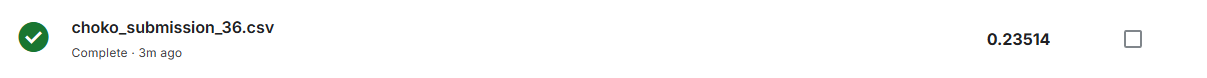

<!-- {'learning_rate': 0.008553940111605946, 'n_estimators': 2114, 'l2_leaf_reg': 1.4163130536678312, 'random_strength': 4.287920281067569, 'bagging_temperature': 0.7916641053388684, 'grow_policy': 'SymmetricTree', 'min_data_in_leaf': 7, 'rsm': 0.9923008576207031} -->

In [ ]:
# {'learning_rate': 0.008553940111605946, 'n_estimators': 2114, 'l2_leaf_reg': 1.4163130536678312, 'random_strength': 4.287920281067569, 'bagging_temperature': 0.7916641053388684, 'grow_policy': 'SymmetricTree', 'min_data_in_leaf': 7, 'rsm': 0.9923008576207031}

In [ ]:
875
0.9676140981916675
0.028993107695535775

0.028993107695535775

In [ ]:
# y_test = pd.read_csv('choko_submission_29.csv', usecols=['Rating']).values.reshape(-1)

# print(SEED)
# r2 = r2_score(y_test, pred)
# print(r2)
# mae = MAE(y_test, pred)
# print(mae)

In [ ]:
from optuna.visualization import plot_optimization_history, plot_param_importances, plot_contour, plot_slice

In [ ]:
plot_optimization_history(study).show()
plot_param_importances(study).show()
# plot_contour(study, params=["max_depth", "n_estimators"]).show()
# plot_slice(study, params=["max_depth", "subsample", "n_estimators"]).show()

ValueError: Parameter max_depth does not exist in your study.